In [1]:
import importlib, helper_functions
importlib.reload(helper_functions)
from helper_functions import plot_distributions

In [9]:
import pandas as pd
from data_loading import build_cap_dataset
from main import judges_promoted_from_district
from helper_functions import norm_id
from helper_functions import plot_distributions
from api_call import _extract_text
import json
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [39]:
promoted = pd.read_csv('results/promoted_judge_stats.csv')
judges = pd.read_csv('data/judge_info.csv')
df = build_cap_dataset()

Working dir: /Users/ilyadavidson/Judge_Promotions_Project/judge_project
Found 28 parquet files for pattern: data/parquet_files/CAP_data_*.parquet


In [135]:
df[(df['opinion_author_raw'].notna()) & (df['opinion_author_id'].isna()) & (df['opinion_author_raw']!='PER CURIAM')]

,name,docket_number,decision_date,court_name,jurisdiction,cite,cites_to,judges_raw,judges_clean,judges_ids,opinion_type,opinion_author_raw,opinion_author_clean,opinion_author_id,opinion_text,unique_id,is_appellate
1,"In re Nicholas BAGLEY, III, Debtor. Nicholas B...",Bankruptcy No. 79-01860 G; Adversary No. 79-00...,1979-10-18,United States District Court for the Eastern D...,U.S.,1 West's Bankruptcy Reporter 116,11 U.S.C. §§ 522,None,[],[],majority,"EMIL F. GOLDHABER, Bankruptcy Judge:",None,NaN,"OPINION\nEMIL F. GOLDHABER, Bankruptcy Judge:\...",1,0
2,"In re Albert E. VAIL and Rita M. Vail, his wif...",Bankruptcy No. 77-433WK,1979-10-29,United States District Court for the Eastern D...,U.S.,1 West's Bankruptcy Reporter 132,"595 Federal Reporter 2d Series 185, 454 Federa...",None,[],[],majority,"KING, Bankruptcy Judge.",None,NaN,"OPINION\nKING, Bankruptcy Judge.\nPlaintiff, T...",2,0
3,"In re BUTCHER BOY MEAT MARKET, INC., Debtor. A...",Bankruptcy No. 78-466WK,1979-11-05,United States District Court for the Eastern D...,U.S.,1 West's Bankruptcy Reporter 155,"5 L.Ed.2d 696, 81 S.Ct. 690, 365 United States...",None,[],[],majority,"WILLIAM A. KING, Jr., Bankruptcy Judge.",None,NaN,"OPINION\nWILLIAM A. KING, Jr., Bankruptcy Judg...",3,0
4,"In re Philip SOLTOFF and Elaine Soltoff, his w...",Bankruptcy No. 77-978WK,1979-11-08,United States District Court for the Eastern D...,U.S.,1 West's Bankruptcy Reporter 180,"470 F.Supp. 869, 51 L.Ed.2d 540, 97 S.Ct. 1107...",None,[],[],majority,"WILLIAM A. KING, Jr., Bankruptcy Judge.",None,NaN,"OPINION\nWILLIAM A. KING, Jr., Bankruptcy Judg...",4,0
5,"In re Jean Anne KALNAS, Bankrupt. COMMONWEALTH...",Bankruptcy No. 77-1336 TT,1979-11-14,United States District Court for the Eastern D...,U.S.,1 West's Bankruptcy Reporter 193,"4 BCD 793, 5 BCD 532, 4 BCD 796, 20 U.S.C. § 1...",None,[],[],majority,"THOMAS M. TWARDOWSKI, Bankruptcy Judge:",None,NaN,"OPINION\nTHOMAS M. TWARDOWSKI, Bankruptcy Judg...",5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104528,"IN RE: ASHINC CORPORATION, et al., Debtors. AS...",No. 16-2206,2017-03-23,United States Court of Appeals for the Third C...,U.S.,683 F. App'x 131,"8 North Eastern Reporter 3d 849, 985 N.Y.S.2d ...","Before: FISHER, KRAUSE and MELLOY, Circuit Jud...","[fisher, krause]","[3047, 3554]",majority,"MELLOY, Circuit Judge.",None,NaN,"OPINION\nMELLOY, Circuit Judge.\nAppellants Yu...",104528,1
104535,"Joseph ARUANNO, Appellant v. Steven JOHNSON; G...",No. 16-4259,2017-03-22,United States Court of Appeals for the Third C...,U.S.,683 F. App'x 172,"316 Federal Reporter 3d Series 257, 174 L.Ed.2...","Before: AMBRO, KRAUSE and NYGAARD, Circuit Judges","[ambro, krause, nygaard]","[2850, 3554, 1790]",majority,PER CURIUM,None,NaN,OPINION\nPER CURIUM\nJoseph Aruanno appeals fr...,104535,1
104559,"Paris Marcelle MYERS, Appellant v. COMMISSIONE...",No. 16-3142,2017-04-11,United States Court of Appeals for the Third C...,U.S.,684 F. App'x 186,"81 Fed. Reg. 66138, 78 Fed. Reg. 46499, 225 Fe...","Before: FISHER , KRAUSE and MELLOY , Circuit J...","[fisher, krause]","[3047, 3554]",majority,"MELLOY, Circuit Judge.",None,NaN,"OPINION\nMELLOY, Circuit Judge.\nParis Myers a...",104559,1
104566,UNITED STATES of America v. Dante Keleek DARBY...,No. 16-2998,2017-03-30,United States Court of Appeals for the Third C...,U.S.,684 F. App'x 219,"719 Federal Reporter 3d Series 139, 827 Federa...","Before: SMITH, Chief Judge, HARDIMAN and KRAUS...","[hardiman, krause]","[3044, 3554]",majority,"SMITH, Chief Judge.",None,NaN,"OPINION\nSMITH, Chief Judge.\nDefendant Dante ...",104566,1


In [49]:
judges[judges['last name']=='melloy']

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,committee action date,senate vote type,ayes/nays,confirmation date,commission date,school 1,degree 1,school 2,degree 2,professional career
2448,1616,melloy,Michael,Male,White,1948,Dubuque,IA,NaN,,...,1992-08-12,Voice,,1992-08-12,1992-08-17,Loras College,B.A.,University of Iowa College of Law,J.D.,"U.S. Army, 1970-1972; U.S. Army Reserve, 1972-..."
4348,1616,melloy,Michael,Male,White,1948,Dubuque,IA,NaN,,...,2002-02-07,Roll Call,91/0,2002-02-11,2002-02-14,Loras College,B.A.,University of Iowa College of Law,J.D.,"U.S. Army, 1970-1972; U.S. Army Reserve, 1972-..."


In [190]:
len(judges)

4674

In [185]:
aj = judges[judges['court type'].str.contains('Appeals|Circuit', case=False, na=False)]

In [186]:
dj = judges[judges['court type'].str.contains('District')]

In [187]:
len(aj)

962

In [178]:
len(dj)

3453

In [188]:
pj = dj[dj['judge id'].isin(aj['judge id'])].copy()

In [189]:
len(pj)

335

In [181]:
def judges_promoted_from_district(judge_info):
    """
    Returns a df of all judges who got promoted from district to appellate courts. Their promotion date is the earliest nomination date that they got to the appellate court. 
    """
    aj = judge_info[judge_info['court type'].str.contains('Appeals|Circuit', case=False, na=False)]
    dj = judge_info[judge_info['court type'].str.contains('District')]
    pj = dj[dj['judge id'].isin(aj['judge id'])].copy()
    pj['nomination date'] = pd.to_datetime(pj['nomination date'], errors='coerce')
    pj = pj.sort_values(['judge id','nomination date']).drop_duplicates('judge id', keep='first')
    return pj

In [191]:
pj = judges_promoted_from_district(judges)

In [192]:
len(pj)

322

In [134]:
len(df[df['opinion_author_id']==2])

41

In [143]:
def compute_district_overturns(
    df:             pd.DataFrame,
    judge_info:     pd.DataFrame,
    api_path:       str = "batch_runs/api_responses.jsonl",
    mapping_path:   str = "results/appellate_matches.json",
) -> pd.DataFrame:
    """
    Computes district-level overturn rates for judges promoted from district to appellate courts.
    Returns a subset of `judge_info` with added columns for the overturn rates of promoted appellate judges.
    """

    # Initialization
    # List per judge what cases they've done, so we can iterrate over the cases and see which ones got overturned
    ####################################################################################################################
    pj                     = judges_promoted_from_district(judge_info)
    dsc                    = df[df['is_appellate']==0].copy()
    dsc["_author_id_norm"] = dsc["opinion_author_id"].map(norm_id)

    by_judge_cases = (
        dsc
        .dropna(subset=["_author_id_norm"])
        .groupby("_author_id_norm")
        .apply(lambda g: list(g.index))
        .to_dict()
    )

    pj["_judge_id_norm"]        = pj["judge id"].map(norm_id)
    pj["district_cases_list"]   = pj["_judge_id_norm"].map(by_judge_cases).apply(lambda x: x if isinstance(x, list) else [])
    pj["district cases"]        = pj["district_cases_list"].str.len().astype(int)

    # Load the appellate to district mapping and check which appellate cases were overturned
    ####################################################################################################################
    with open(mapping_path, "r", encoding="utf-8") as f:
        app_to_dct = json.load(f)

    # API info
    overturned_district_indices = set()
    with open(api_path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip(): 
                continue
            rec = json.loads(line)
            if rec.get("error"):
                continue
            txt = _extract_text(rec.get("response", {}))
            if not txt:
                continue
            try:
                obj = json.loads(txt)  # 9-key JSON from model
            except json.JSONDecodeError:
                continue
            opinion = obj.get("opinion")
            if opinion is None:
                continue
            if opinion != "affirmed":
                app_id = str(rec.get("custom_id"))
                if app_id in app_to_dct:
                    try:
                        overturned_district_indices.add(int(app_to_dct[app_id]))
                    except Exception:
                        # ignore non-integer district indices
                        pass

    # Get the overturn counts per judge
    ####################################################################################################################
    def _count_overturned(case_list):
        if not case_list:
            return 0
        return sum(1 for cid in case_list if cid in overturned_district_indices)

    pj["district_cases_overturned"]         = pj["district_cases_list"].apply(_count_overturned).astype(int)
    pj["district_overturn_rate"]            = pj.apply(
        lambda r: (r["district_cases_overturned"] / r["district cases"]) if r["district cases"] else pd.NA,
        axis=1
    )
    pj.drop(columns=["_judge_id_norm"], inplace=True)

    return pj

In [148]:
pj = compute_district_overturns(df, judges)

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_52381/95084393.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: list(g.index))


In [151]:
len(pj)

773

In [ ]:
pj.sort_values(by="district_overturn_rate", ascending=False).head(20)

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,degree 1,school 2,degree 2,professional career,promotion date,promoted,district_cases_list,district cases,district_cases_overturned,district_overturn_rate
4106,445,clark,William,Male,White,1891,Newark,NJ,1957.0,Nuwara Eliya,...,B.A.,Harvard University,M.A.,"U.S. Army, 1917-1918, 1942-1945; Private pract...",1938-06-10,1,"[11253, 11381, 48420]",3,2,0.666667
680,445,clark,William,Male,White,1891,Newark,NJ,1957.0,Nuwara Eliya,...,B.A.,Harvard University,M.A.,"U.S. Army, 1917-1918, 1942-1945; Private pract...",1938-06-10,1,"[11253, 11381, 48420]",3,2,0.666667
4049,109,barry,Maryanne,Female,White,1937,New York,NY,2023.0,New York,...,B.A.,Columbia University,M.A.,"Assistant U.S. attorney, District of New Jerse...",1999-06-17,1,"[1472, 3165, 3644, 4260, 28180, 28314, 28316, ...",98,11,0.112245
173,109,barry,Maryanne,Female,White,1937,New York,NY,2023.0,New York,...,B.A.,Columbia University,M.A.,"Assistant U.S. attorney, District of New Jerse...",1999-06-17,1,"[1472, 3165, 3644, 4260, 28180, 28314, 28316, ...",98,11,0.112245
480,313,buffington,Joseph,Male,White,1855,Kittanning,PA,1947.0,Pittsburgh,...,A.B.,Read law,NaN,"Private practice, Kittanning, Pennsylvania, 18...",1906-12-03,1,"[78822, 78832, 78838, 78851, 78852, 78853, 788...",116,13,0.112069
4578,313,buffington,Joseph,Male,White,1855,Kittanning,PA,1947.0,Pittsburgh,...,A.B.,Read law,NaN,"Private practice, Kittanning, Pennsylvania, 18...",1906-12-03,1,"[78822, 78832, 78838, 78851, 78852, 78853, 788...",116,13,0.112069
4085,313,buffington,Joseph,Male,White,1855,Kittanning,PA,1947.0,Pittsburgh,...,A.B.,Read law,NaN,"Private practice, Kittanning, Pennsylvania, 18...",1906-12-03,1,"[78822, 78832, 78838, 78851, 78852, 78853, 788...",116,13,0.112069
3012,3482,restrepo,Luis,Male,Hispanic,1959,Medellin,Colombia,NaN,,...,B.A.,Tulane University Law School,J.D.,"Law clerk, ACLU National Prison Project, Washi...",2015-01-07,1,"[44659, 44832, 44871, 44872, 44928, 44958, 450...",19,2,0.105263
4414,3482,restrepo,Luis,Male,Hispanic,1959,Medellin,Colombia,NaN,,...,B.A.,Tulane University Law School,J.D.,"Law clerk, ACLU National Prison Project, Washi...",2015-01-07,1,"[44659, 44832, 44871, 44872, 44928, 44958, 450...",19,2,0.105263
4179,781,forman,Phillip,Male,White,1895,New York,NY,1978.0,Trenton,...,LL.B.,NaN,NaN,"U.S. Navy, 1917-1919; Private practice, Trento...",1959-02-09,1,"[10026, 10060, 10194, 10263, 10266, 10353, 105...",249,15,0.060241


In [201]:
df

,id,custom_id,response,error,message
0,batch_req_68d459471cfc8190b0b04defb70fb9d2,0,"{'status_code': 200, 'request_id': 'b0b935d6db...",NaN,None
1,batch_req_68d459483784819095a0031bce70906b,39,"{'status_code': 200, 'request_id': 'f6db0e1da6...",NaN,None
2,batch_req_68d4594763e0819085ac72b428edfe4f,40,"{'status_code': 200, 'request_id': '7514ee73bb...",NaN,None
3,batch_req_68d459482cb481909da32185b01dcff5,87,"{'status_code': 200, 'request_id': '2260c1a5d7...",NaN,None
4,batch_req_68d459470e8c8190a14a96dd3efbee3e,91,"{'status_code': 200, 'request_id': 'a1acd75a81...",NaN,None
...,...,...,...,...,...
45335,batch_req_68d5086d75248190974e2f75c40f8dbe,92,"{'status_code': 200, 'request_id': 'c10a698a9c...",NaN,None
45336,batch_req_68d5086d7ac8819080d355258b318c80,124,"{'status_code': 200, 'request_id': 'f51b28d829...",NaN,None
45337,batch_req_68d5086d7078819084a9308309409c84,154,"{'status_code': 200, 'request_id': 'ae57cd3a57...",NaN,None
45338,batch_req_68d5086de214819092dc7bd3675eb17f,155,"{'status_code': 200, 'request_id': 'd0200935d8...",NaN,None


In [214]:
df[df['name'].str.contains('In re Gerard J. CANTWELL', na=False)]

,name,docket_number,decision_date,court_name,jurisdiction,cite,cites_to,judges_raw,judges_clean,judges_ids,opinion_type,opinion_author_raw,opinion_author_clean,opinion_author_id,opinion_text,unique_id,is_appellate
155,"In re Gerard J. CANTWELL, Debtor. Appeal of CO...",No. 80-1711,1981-02-04,United States Court of Appeals for the Third C...,U.S.,639 Federal Reporter 2d Series 1050,"11 U.S.C. § 727, 103 U.Pa.L.Rev. 772, 26 L.Ed....","Before ADAMS and SLOVITER, Circuit Judges, and...","[adams, sloviter]","[8, 2208]",majority,"SLOVITER, Circuit Judge.",sloviter,2208.0,"OPINION OF THE COURT\nSLOVITER, Circuit Judge....",155,1
156,"In re Gerard J. CANTWELL, Debtor. Appeal of CO...",No. 80-1711,1981-02-04,United States Court of Appeals for the Third C...,U.S.,639 Federal Reporter 2d Series 1050,"11 U.S.C. § 727, 103 U.Pa.L.Rev. 772, 26 L.Ed....","Before ADAMS and SLOVITER, Circuit Judges, and...","[adams, sloviter]","[8, 2208]",concurrence,"ADAMS, Circuit Judge,",adams,8.0,"ADAMS, Circuit Judge,\nconcurring in the resul...",156,1
388,"In re Gerard J. CANTWELL, Bankrupt. CONTINENTA...",Bankruptcy No. 78-918G,1982-02-09,United States District Court for the Eastern D...,U.S.,17 West's Bankruptcy Reporter 639,"7 Federal Reporter 2d Series 135, 11 West's Ba...",None,[],[],majority,"EMIL F. GOLDHABER, Bankruptcy Judge:",None,NaN,"EMIL F. GOLDHABER, Bankruptcy Judge:\nThe issu...",388,0
62407,"In re Gerard J. CANTWELL, Debtor. Appeal of CO...",No. 80-1711,1981-02-04,United States Court of Appeals for the Third C...,U.S.,639 Federal Reporter 2d Series 1050,"11 U.S.C. § 727, 103 U.Pa.L.Rev. 772, 26 L.Ed....","Before ADAMS and SLOVITER, Circuit Judges, and...","[adams, sloviter]","[8, 2208]",majority,"SLOVITER, Circuit Judge.",sloviter,2208.0,"OPINION OF THE COURT\nSLOVITER, Circuit Judge....",62407,1
62408,"In re Gerard J. CANTWELL, Debtor. Appeal of CO...",No. 80-1711,1981-02-04,United States Court of Appeals for the Third C...,U.S.,639 Federal Reporter 2d Series 1050,"11 U.S.C. § 727, 103 U.Pa.L.Rev. 772, 26 L.Ed....","Before ADAMS and SLOVITER, Circuit Judges, and...","[adams, sloviter]","[8, 2208]",concurrence,"ADAMS, Circuit Judge,",adams,8.0,"ADAMS, Circuit Judge,\nconcurring in the resul...",62408,1


In [215]:
df[df['unique_id']=='155']

,name,docket_number,decision_date,court_name,jurisdiction,cite,cites_to,judges_raw,judges_clean,judges_ids,opinion_type,opinion_author_raw,opinion_author_clean,opinion_author_id,opinion_text,unique_id,is_appellate
155,"In re Gerard J. CANTWELL, Debtor. Appeal of CO...",No. 80-1711,1981-02-04,United States Court of Appeals for the Third C...,U.S.,639 Federal Reporter 2d Series 1050,"11 U.S.C. § 727, 103 U.Pa.L.Rev. 772, 26 L.Ed....","Before ADAMS and SLOVITER, Circuit Judges, and...","[adams, sloviter]","[8, 2208]",majority,"SLOVITER, Circuit Judge.",sloviter,2208.0,"OPINION OF THE COURT\nSLOVITER, Circuit Judge....",155,1


In [7]:
import json
import pandas as pd

def load_case_results(path: str) -> pd.DataFrame:
    records = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            rec = json.loads(line)

            # Skip error lines
            if rec.get("error"):
                continue

            # Get the model’s JSON string
            try:
                content = rec["response"]["body"]["choices"][0]["message"]["content"]
                obj = json.loads(content)  # parse the 9-key JSON
            except Exception:
                continue

            # Attach your own ID (custom_id)
            obj["custom_id"] = rec.get("custom_id")

            records.append(obj)

    return pd.DataFrame.from_records(records)

In [15]:
case_results = load_case_results("batch_runs/api_responses.jsonl")
case_results.sample(1)

,opinion,case_type,error_category,petitioner_type,respondent_type,politicality_score,profile_level,lower_judge_first,lower_judge_last,custom_id
13905,vacated,criminal,abuse of discretion,male,other,4.0,low,None,None,66581


In [19]:
case_results[case_results['politicality_score']==5]

,opinion,case_type,error_category,petitioner_type,respondent_type,politicality_score,profile_level,lower_judge_first,lower_judge_last,custom_id
3554,reversed,criminal,new or controlling precedent,None,None,5.0,high,None,None,50222
9465,affirmed,civil,legal error,other,group of individuals,5.0,high,None,None,62141
9466,affirmed,civil,legal error,other,group of individuals,5.0,medium,None,None,62142
11119,affirmed,civil,constitutional violation,group of individuals,other,5.0,high,None,None,63795
13150,remanded,civil,procedural error,group of individuals,other,5.0,high,None,None,65826
14623,modified,civil,constitutional violation,group of individuals,other,5.0,high,None,None,67299
17549,affirmed,civil,constitutional violation,group of individuals,group of individuals,5.0,high,None,None,70225
17550,affirmed,civil,new or controlling precedent,group of individuals,group of individuals,5.0,high,None,None,70226
17813,vacated,civil,procedural error,group of individuals,other,5.0,medium,None,None,70489
19992,affirmed,criminal,constitutional violation,male,other,5.0,high,None,None,72668


In [20]:
df[df['unique_id']=='63795']

,name,docket_number,decision_date,court_name,jurisdiction,cite,cites_to,judges_raw,judges_clean,judges_ids,opinion_type,opinion_author_raw,opinion_author_clean,opinion_author_id,opinion_text,unique_id,is_appellate
63795,AMERICAN COLLEGE OF OBSTETRICIANS AND GYNECOLO...,"Nos. 82-1785, 82-1846",1984-05-31,United States Court of Appeals for the Third C...,U.S.,737 Federal Reporter 2d Series 283,"507 Federal Reporter 2d Series 1363, 721 Feder...",None,[],[],dissent,"SEITZ, Chief Judge,",seitz,2139.0,"SEITZ, Chief Judge,\ndissenting in part.\nI co...",63795,1


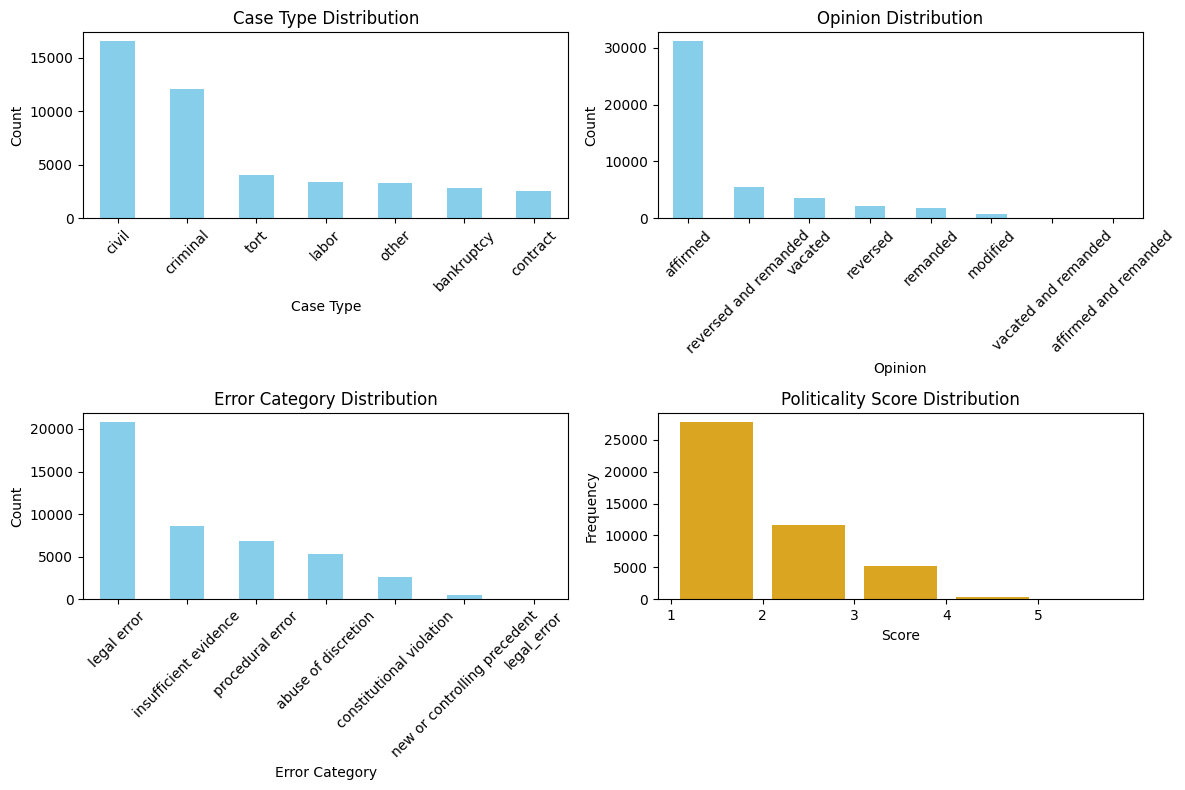

In [244]:
plot_distributions(df, ["case_type", "opinion", "error_category", "politicality_score"])

In [22]:
df.columns

Index(['name', 'docket_number', 'decision_date', 'court_name', 'jurisdiction',
       'cite', 'cites_to', 'judges_raw', 'judges_clean', 'judges_ids',
       'opinion_type', 'opinion_author_raw', 'opinion_author_clean',
       'opinion_author_id', 'opinion_text', 'unique_id', 'is_appellate'],
      dtype='object')

In [24]:
from scipy.stats             import binom, binomtest, false_discovery_control
def get_pval( n_succ, n_tot, baseline, alternative='two-sided' ):
    """
    Return the p-value of a binomial test testing whether a total number of successes (n_succ) out of a total number
    of observations (n_tot) is statistically different from the baseline success rate. 
    """   

    ret  = binomtest(   k           =  n_succ,       # number of successes
                        n           =  n_tot,        # total number of observations
                        p           =  baseline,     # base-line success rate 
                        alternative =  alternative ) # alternative to H_0, i.e.
                                                     # H_0 = 'success rate has baseline probability'
    return ret.pvalue

In [26]:
def false_discovery_correction( pvals, formatted=True ):
    """
    Adjust p-values for multiple testing and count the fraction of values below the 5% threshold. Return either raw or 
    nicely formatted values. 
    """

    th       =  0.05                                          # threshold for significance
    nv       =  len(pvals)                                    # number of p-values
    by_pvals =  false_discovery_control( pvals, method='by' ) # adjust p-values for multiple testing
    bh_pvals =  false_discovery_control( pvals, method='bh' ) # adjust p-values for multiple testing
    raw      =  ( pvals    < th ).sum()    / len(pvals)       # frac below th w/o correction
    bf       =  ( pvals    < th/nv ).sum() / len(pvals)       # frac below th with Bonferroni correction
    by       =  ( by_pvals < th ).sum()    / len(pvals)       # frac below th with Benjamini-Yekutieli correction
    bh       =  ( bh_pvals < th ).sum()    / len(pvals)       # frac below th with Benjamini-Hochberg correction

    if not formatted: return {'raw':raw, 'bf':bf, 'bh':bh, 'by':by, }

    txt      = f'nr of p-values: {nv:,}' + '\n'
    txt     += f'uncorrected fraction of values below {th}: {100*raw:.1f}%' + '\n'
    txt     += f'Bonferroni corrected fraction below {th}: {100*bf:.1f}%'  + '\n'
    txt     += f'Benjamini-Yekutieli corrected fraction below {th}: {100*by:.1f}%' + '\n'
    txt     += f'Benjamini-Hochberg corrected fraction below {th}: {100*bh:.1f}%' 

    return txt  

In [27]:
def create_subplots( nplots, n_cols=2, width=8, height=4, **kwargs ):
    """
    Automatically create a smart arrangement of subplots. 

    :param nplots:      number of subplots
    :param n_cols:      number of columns
    :param width:       figure width
    :param height:      figure height 
    :param kwargs:      additional arguments for the subplots function
    """

    n_rows    = nplots // n_cols if nplots%n_cols==0 else nplots//n_cols + 1
    rem       = n_cols - nplots%n_cols # number of empty plots in last row
    figsize   = (width*n_cols, height*n_rows)
    fig, axs  = plt.subplots(n_rows, n_cols, figsize=figsize, **kwargs )
    _         = fig.subplots_adjust(hspace=0.25, wspace=0.1)

    if rem < n_cols: 
        for i in range(1,rem+1): # turn off windows in last row
            axs.flatten()[-i].set_visible(False) 

    return fig, axs 

In [45]:
df.columns

Index(['name', 'docket_number', 'decision_date', 'court_name', 'jurisdiction',
       'cite', 'cites_to', 'judges_raw', 'judges_clean', 'judges_ids',
       'opinion_type', 'opinion_author_raw', 'opinion_author_clean',
       'opinion_author_id', 'opinion_text', 'unique_id', 'is_appellate'],
      dtype='object')

In [49]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt


def examine_assignment_bias_single_pool(
    variable: str = "is_appellate",
    confidence_th: float = 0.4,
    min_cases: int = 100,
    outdir: str | None = None,
    retvals: bool = False,
):
    """
    Single-circuit, single-pool binomial screen for judge-level assignment bias.

    - Baseline is computed over the entire dataset (no circuit/decade split).
    - Works for:
        * Categorical variables (e.g., 'case_type', 'entity_label')
        * Binary 0/1 variables (e.g., 'appealed')

    Parameters
    ----------
    variable : str
        Column to test (categorical or binary 0/1).
    confidence_th : float
        Filter threshold passed to `load_raw_features`.
    min_cases : int
        Minimum total cases per judge required to run the test.
    outdir : str | None
        If provided, results (parquet + plot) will be saved here. Directory is created if missing.
    retvals : bool
        If True, return (pvals_df, qq_df) instead of plotting/saving.

    Returns
    -------
    (pvals_df, qq_df) if retvals; otherwise None.
    """

    # Load and keep columns we need
    df = df.copy()
    needed = ["judge_id", variable]
    missing = [c for c in needed if c not in df.columns]
    assert not missing, f"Missing required columns: {missing}"

    df = df[needed].copy()

    # Drop "unsure" for categorical variables
    if df[variable].dtype == object:
        df = df[df[variable] != "unsure"]

    # Decide if variable is binary 0/1 or categorical
    is_binary = False
    if pd.api.types.is_bool_dtype(df[variable]):
        is_binary = True
        df[variable] = df[variable].astype(int)
    elif pd.api.types.is_numeric_dtype(df[variable]):
        # treat as binary if only 0/1 appear
        uniq = set(pd.unique(df[variable].dropna()))
        if uniq.issubset({0, 1}):
            is_binary = True
            df[variable] = df[variable].astype(int)

    pvals = []

    if is_binary:
        # Baseline = overall rate of 1s
        bl = df[variable].mean()
        if bl == 0 or bl == 1:
            print("All outcomes identical; cannot test (baseline is 0 or 1).")
            return (pd.DataFrame(), pd.DataFrame()) if retvals else None

        for judge, jdf in df.groupby("judge_id"):
            totc = len(jdf)
            if totc < min_cases:
                continue
            nc = jdf[variable].sum()
            pval = get_pval(n_succ=int(nc), n_tot=int(totc), baseline=float(bl))
            pvals.append({
                "judge": judge,
                "subset": str(1),         # “success” category for binary
                "baseline": bl,
                "nr_cases": int(nc),
                "total_nr_cases": int(totc),
                "obs_rate": nc / totc,
                "pval": pval
            })

    else:
        # Categorical: loop each level as the "success" subset
        for subset, ssdf in df.groupby(variable):
            # Baseline = share of this subset in entire pool
            bl = len(ssdf) / len(df)
            if len(ssdf) < min_cases:
                # If the subset itself is extremely rare, skip (too noisy)
                continue

            # For each judge: how many of this subset vs total for that judge?
            # (Total is over ALL their cases, not just this subset.)
            # Build a quick lookup of judge totals to avoid recomputing.
            totals = df.groupby("judge_id").size().rename("total_nr_cases")

            counts = ssdf.groupby("judge_id").size().rename("nr_cases").to_frame()
            counts = counts.join(totals, how="left").dropna()
            counts = counts[counts["total_nr_cases"] >= min_cases]

            for judge, row in counts.iterrows():
                nc = int(row["nr_cases"])
                totc = int(row["total_nr_cases"])
                pval = get_pval(n_succ=nc, n_tot=totc, baseline=float(bl))
                pvals.append({
                    "judge": judge,
                    "subset": str(subset),
                    "baseline": bl,
                    "nr_cases": nc,
                    "total_nr_cases": totc,
                    "obs_rate": nc / totc,
                    "pval": pval
                })

    pvals = pd.DataFrame(pvals)
    if pvals.empty:
        print("No judges met min_cases or no testable data.")
        return (pvals, pd.DataFrame()) if retvals else None

    # Multiple testing correction summary (kept simple, like your code)
    fdr_info = false_discovery_correction(pvals["pval"])

    # QQ-like empirical line (single pool, no stratification)
    ps = np.linspace(0.05, 0.95, 19)
    judges = pvals["judge"].unique()
    qq = []

    # Subsample for variability bands
    if len(judges) >= 10:
        subs = [np.random.choice(judges, size=max(10, len(judges)//2), replace=False) for _ in range(50)]
        for subset, sdf in pvals.groupby("subset"):
            for p in ps:
                fracs = []
                for s in subs:
                    d = sdf[sdf["judge"].isin(s)]
                    if len(d) == 0:
                        continue
                    fracs.append((d["pval"] <= p).mean())
                if fracs:
                    qq.append({
                        "subset": subset,
                        "p": p,
                        "frac_mean": np.mean(fracs),
                        "frac_std": np.std(fracs)
                    })

    qq_df = pd.DataFrame(qq)

    if retvals:
        return pvals, qq_df

    # Save (optional)
    if outdir:
        os.makedirs(outdir, exist_ok=True)
        pvals.to_parquet(os.path.join(outdir, f"{variable}_pvalues.parquet"))
        if not qq_df.empty:
            qq_df.to_parquet(os.path.join(outdir, f"{variable}_qq.parquet"))
        with open(os.path.join(outdir, f"{variable}_fdr.txt"), "w") as f:
            print(fdr_info, file=f)

    # Plot
    _ = sb.set_style("whitegrid")

    subsets = sorted(pvals["subset"].unique())
    nplots = max(1, len(subsets))
    ncols = min(2, nplots)
    nrows = int(np.ceil(nplots / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4.5*nrows), sharex=True, sharey=True)
    if nplots == 1:
        axs = np.array([axs])

    for i, subset in enumerate(subsets):
        ax = axs.flatten()[i]
        ax.plot([0, 0.95], [0, 0.95], linestyle=":", linewidth=2.5, color="black", label="uniform(0,1)")
        if not qq_df.empty:
            sqq = qq_df[qq_df["subset"] == subset]
            if not sqq.empty:
                ax.errorbar(
                    sqq["p"], sqq["frac_mean"], yerr=sqq["frac_std"],
                    fmt="o", linestyle="none", alpha=0.7
                )
        ax.set_title(f"{variable}: {subset}")
        ax.set_xlabel("p-value")
        ax.set_ylabel("empirical fraction ≤ p")
        ax.set_xlim(0.04, 0.96)

    # hide any empty axes
    for j in range(i+1, len(axs.flatten())):
        axs.flatten()[j].set_visible(False)

    if outdir:
        fig.savefig(os.path.join(outdir, f"{variable}_bias_single_pool.pdf"), bbox_inches="tight")
    plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [44]:
examine_appeal_bias()

KeyError: "['court_name'] not in index"